In [1]:
import cvxpy as cvx
import numpy as np
import imageio.v3 as iio
import scipy
import random
import matplotlib.pyplot as plt

In [2]:
Y = iio.imread('SheppLogan_150x150.png')
Y = Y / Y.max()
n1, n2 = Y.shape

In [3]:
orig_shape = Y.shape
flat = Y.flatten()
n_mutated = len(flat) // 10
rand_idxs = random.sample(range(0,len(flat)-1), n_mutated)
flat[rand_idxs] += np.random.rand(n_mutated).astype(np.float32)
Y_noisy = flat.reshape(orig_shape)

In [4]:
D = np.zeros(Y.shape)
for i in range(n1-1):
    D[i,i] = -1
    D[i, i+1] = 1

D[n1-1, n2-1] = -1
Lh_tilde = scipy.sparse.kron(D, np.identity(n1))
Lv_tilde = scipy.sparse.kron(np.identity(n2), D)

In [5]:
def TV(X):
    X = X.flatten()
    y_h = Lh_tilde @ X
    y_v = Lv_tilde @ X
    y = np.vstack((y_h, y_v))
    return np.sum(np.linalg.norm(y, 2, axis=0))

def TV_cvx(X):
    X = X.flatten()
    y_h = Lh_tilde @ X
    y_v = Lv_tilde @ X
    y = cvx.vstack((y_h, y_v))
    return cvx.sum(cvx.norm(y, 2, axis=0))

tau = 0.25*TV(Y_noisy)

In [6]:
X = cvx.Variable((n1,n2))
objective = cvx.Minimize(0.5*cvx.norm(Y_noisy-X,'fro'))
constraints = [0 <= X, X <= 1, TV_cvx(X) <= tau]
prob = cvx.Problem(objective, constraints)
result = prob.solve()
Y_pred = X.value

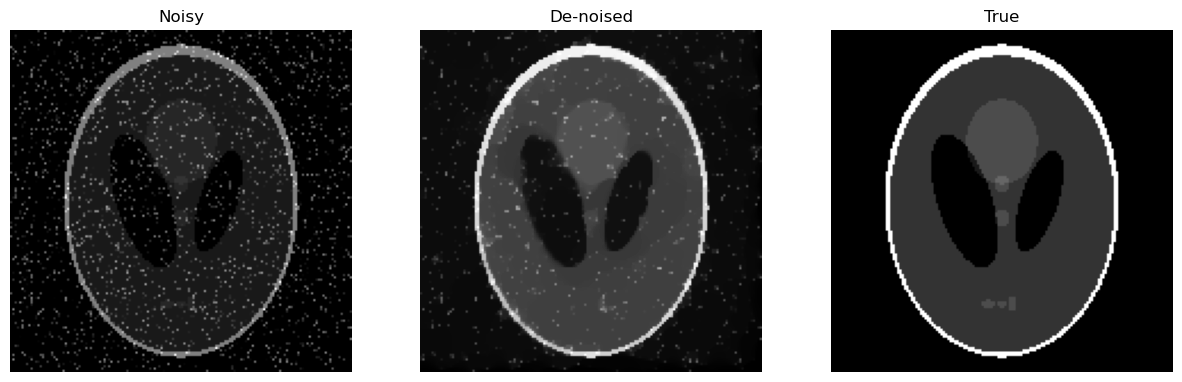

In [7]:
fig, axes = plt.subplots(1,3,figsize=(15,7))
axes[0].imshow(Y_noisy, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Noisy")
axes[1].imshow(Y_pred, cmap='gray')
axes[1].axis('off')
axes[1].set_title("De-noised")
axes[2].imshow(Y, cmap='gray')
axes[2].axis('off')
axes[2].set_title("True")
plt.show()